In [3]:
import json
from hf_utils import get_splits, get_stats, get_size_stats, search
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display
import pandas as pd
load_dotenv()
sns.set_theme()

## Data splits

In [4]:
splits = get_splits()

In [14]:
df_split = pd.DataFrame(splits['splits'])
df_split.sample(7)

,dataset,config,split
34,HuggingFaceFW/fineweb,CC-MAIN-2017-22,train
29,HuggingFaceFW/fineweb,CC-MAIN-2016-50,train
16,HuggingFaceFW/fineweb,CC-MAIN-2015-27,train
56,HuggingFaceFW/fineweb,CC-MAIN-2019-13,train
87,HuggingFaceFW/fineweb,CC-MAIN-2022-33,train
77,HuggingFaceFW/fineweb,CC-MAIN-2021-17,train
94,HuggingFaceFW/fineweb,CC-MAIN-2023-50,train


In [11]:
df_split.config.nunique()

96

## Size statistics

> The dataset viewer provides a `/statistics` endpoint for fetching some basic statistics precomputed for a requested dataset. This will get you a quick insight on how the data is distributed.

In [70]:
res = get_size_stats()

In [71]:
res.keys()

dict_keys(['size', 'pending', 'failed', 'partial'])

In [72]:
print(json.dumps(res, indent=4))

{
    "size": {
        "dataset": {
            "dataset": "HuggingFaceFW/fineweb",
            "num_bytes_original_files": 44968561341369,
            "num_bytes_parquet_files": 44968561341369,
            "num_bytes_memory": 80272517552332,
            "num_rows": 22335106879
        },
        "configs": [
            {
                "dataset": "HuggingFaceFW/fineweb",
                "config": "CC-MAIN-2013-20",
                "num_bytes_original_files": 422996258185,
                "num_bytes_parquet_files": 422996258185,
                "num_bytes_memory": 784077782405,
                "num_rows": 215405925,
                "num_columns": 9
            },
            {
                "dataset": "HuggingFaceFW/fineweb",
                "config": "CC-MAIN-2013-48",
                "num_bytes_original_files": 426088942450,
                "num_bytes_parquet_files": 426088942450,
                "num_bytes_memory": 800948173577,
                "num_rows": 220467287,
          

In [73]:
display(Markdown(f"""
**{round(res['size']['dataset']['num_bytes_parquet_files']/(1024**3), 3):,}** GiB
<br>
**{res['size']['dataset']['num_rows']:,}** rows
"""))


**41,880.236** GiB
<br>
**22,335,106,879** rows


In [74]:
df = pd.DataFrame(res['size']['configs'])

In [75]:
df.describe()

,num_bytes_original_files,num_bytes_parquet_files,num_bytes_memory,num_rows,num_columns
count,9.500000e+01,9.500000e+01,9.500000e+01,9.500000e+01,95.0
mean,4.733533e+11,4.733533e+11,8.449739e+11,2.351064e+08,9.0
std,8.543134e+10,8.543134e+10,1.647791e+11,4.262735e+07,0.0
min,2.754380e+11,2.754380e+11,4.772803e+11,1.315320e+08,9.0
25%,4.158639e+11,4.158639e+11,7.457545e+11,2.054806e+08,9.0
50%,4.647040e+11,4.647040e+11,8.222143e+11,2.280161e+08,9.0
75%,5.270434e+11,5.270434e+11,9.233581e+11,2.662878e+08,9.0
max,6.979284e+11,6.979284e+11,1.315635e+12,3.250136e+08,9.0


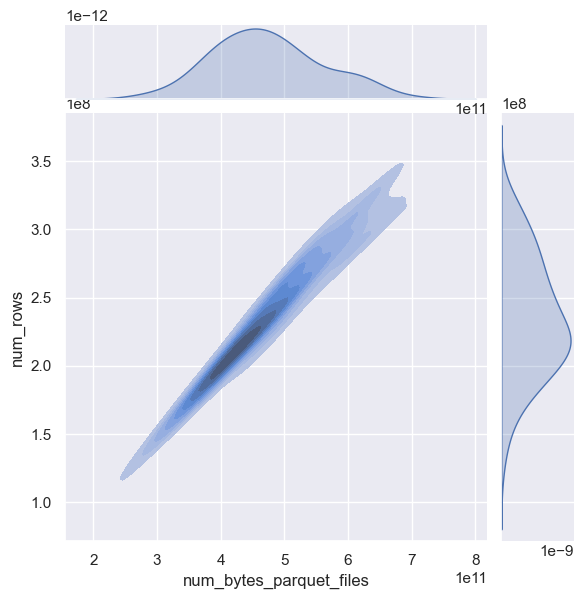

In [76]:
# sns.kdeplot(data=df, x="num_bytes_parquet_files", y='num_rows', levels=5);
sns.jointplot(data=df, x="num_bytes_parquet_files", y='num_rows', kind='kde', fill=True);

## Stats

In [18]:
dump_name=df_split.config.sample(1).values[0]
res = get_stats(dump_name)

In [25]:
stats_df = pd.DataFrame(res['statistics'])
num_examples = res['num_examples']

In [43]:
df = pd.DataFrame()
for dump_name in df_split.config:
    try:
        res = get_stats(dump_name)
        _df = pd.DataFrame(res['statistics'])
        _df['dump_name'] = dump_name
        _df['num_examples'] = res['num_examples']
        df = pd.concat([df, _df])
    except Exception as e:
        print(dump_name, e)
        continue

cols = list(df.column_statistics.values[0].keys())
for col in cols:
    df[col] = df.column_statistics.apply(lambda x: x[col] if col in x else None)
df.drop(columns=['column_statistics'], inplace=True)

default 'statistics'
CC-MAIN-2016-07 'statistics'


In [42]:
res

{'error': 'Job manager crashed while running this job (missing heartbeats).'}

In [44]:
df.sample(10)

,column_name,column_type,dump_name,num_examples,nan_count,nan_proportion,min,max,mean,median,std,histogram
8,url,string_text,CC-MAIN-2017-30,2181000,0,0.0,13.0,2449.0,72.05818,69.0,27.27498,"{'hist': [2179971, 972, 42, 4, 7, 0, 2, 0, 1, ..."
3,id,string_text,CC-MAIN-2018-51,2147000,0,0.0,47.0,47.0,47.00000,47.0,0.00000,"{'hist': [2147000], 'bin_edges': [47, 47]}"
0,date,string_text,CC-MAIN-2015-27,2152000,0,0.0,20.0,20.0,20.00000,20.0,0.00000,"{'hist': [2152000], 'bin_edges': [20, 20]}"
4,language,string_label,CC-MAIN-2015-18,2159000,0,0.0,NaN,NaN,NaN,NaN,NaN,None
8,url,string_text,CC-MAIN-2020-40,2133000,0,0.0,14.0,3298.0,73.77092,69.0,34.97044,"{'hist': [2130773, 1749, 317, 98, 27, 15, 15, ..."
3,id,string_text,CC-MAIN-2021-49,2151000,0,0.0,47.0,47.0,47.00000,47.0,0.00000,"{'hist': [2151000], 'bin_edges': [47, 47]}"
1,dump,string_label,CC-MAIN-2019-18,2100000,0,0.0,NaN,NaN,NaN,NaN,NaN,None
6,text,string_text,CC-MAIN-2019-30,2111000,0,0.0,83.0,668702.0,3084.72350,1875.0,5488.24807,"{'hist': [2109299, 1357, 203, 73, 27, 13, 15, ..."
6,text,string_text,CC-MAIN-2014-42,2125000,0,0.0,89.0,554519.0,3057.75926,1693.0,6697.23032,"{'hist': [2120530, 3434, 601, 220, 87, 38, 34,..."
3,id,string_text,CC-MAIN-2020-10,2111000,0,0.0,47.0,47.0,47.00000,47.0,0.00000,"{'hist': [2111000], 'bin_edges': [47, 47]}"


In [48]:
text_stats = df[df.column_name == 'text']

In [54]:
# weighted min, max, mean, std based on number_examples
row_count = text_stats.num_examples.sum()
min = 0; max = 0; mean = 0; std = 0
for idx, row in text_stats.iterrows():
    min += row['min'] * row.num_examples
    max += row['max'] * row.num_examples
    mean += row['mean'] * row.num_examples
    std += row['std'] * row.num_examples
min = min / row_count
max = max / row_count
mean = mean / row_count
std = std / row_count

In [77]:
display(Markdown(f"""
## Text column stats about character length
#### **min**: {min:.2f} 
#### **max**: {max:.2f} 
#### **mean ± std**: {mean:.2f} ± {std:.2f}
"""))


## Text column stats about character length
#### **min**: 99.19 
#### **max**: 611384.95 
#### **mean ± std**: 3053.66 ± 6048.17


## Does the code reference my `keyword`?

In [115]:
keyword = 'Metaflow'

In [127]:
res = search(dump_name, query=keyword, length=10, offset=0)

In [128]:
mentions = []
for row in res['rows']:
    mentions.append(row['row'])

In [129]:
len(mentions)

4

In [130]:
for m in mentions:
    display(Markdown(f"""
### {m['dump']}
### {m['url']}
    """))
    display(Markdown(m['text'].replace("Metaflow", '<span style="background-color: yellow">Metaflow</span>')))
    display(Markdown('---'))


### CC-MAIN-2024-10
### https://www.businessoutreach.in/buying-virtual-property-with-crypto-in-metaverse-blockchain-based-games
    

Metaverse Gaming Industry promotes the use of Crypto through the gaming experience.
From arcade games in the 70s to today’s PlayStation consoles, from putting in coins to play Super Mario to buying a property in virtual reality with cryptocurrency, the gaming industry has evolved from time to time, to the point one hadn’t imagined.
Metaverse Blockchain-based games are virtual video games, where while exploring a 3D world, one can also monetize their gaming experience. A player can use cryptocurrency or non-fungible tokens to buy, sell or trade with other players. These games come with their own in-game cryptocurrencies. Blockchain technology – originally created to support Bitcoin – helped video game creators build their own ambition.
Some of the most popular games and their cryptos are Decentraland Mana (MANA), Axie Infinity (AXS), and Sandbox (SAND).
Blockchain-based games may not have yet made an impact on the video gaming industry but it has the ability to transform the gaming experience in near future.
Up till today, there have been several crypto transactions throughout many games.
Recently, a player bought <span style="background-color: yellow">Metaflow</span>er Super Mega Yacht for $650,000 by the creator of the Yacht, Republic Realm, a developer in the metaverse real estate ecosystem. “The <span style="background-color: yellow">Metaflow</span>er,” named after one of the ships that transported the pilgrims from England to America, consists of helicopter landing strips, a DJ booth, a Jacuzzi, and other facilities. This transaction has been considered as one of the most expensive NFT (Non-fungible token) ever sold in “The Sandbox.”
Before this, a digital piece of land on Decetraland metaverse was sold for around $2.5 million, and another plot in Axie Infinity for $2.3 million.
Other than gamers, these transactions certainly feel to be a waste of good money. But the gamers perceive games like The Sandbox and Dectraland as more than just a virtual world.

---


### CC-MAIN-2024-10
### https://www.bidya.com/coin/NGC
    

|All Time High:
|The price of #NGC today is $0.036 USD.
The lowest NGC price for this period was $0, the highest was $0.036, and the current live price for one NGC coin is $0.03598.
The all-time high NGC coin price was $3.59.
Use our custom price calculator to see the hypothetical price of NGC with market cap of SOL or other crypto coins.
|The code for NAGA crypto currency is #NGC.
NAGA is 6.1 years old.
|The current market capitalization for NAGA is $2,803,210.
NAGA is ranking downwards to #1214 out of all coins, by market cap (and other factors).
|There is a modest volume of trading today on #NGC.
Today's 24-hour trading volume across all exchanges for NAGA is $20,166.
|The circulating supply of NGC is 77,910,266 coins, which is 100% of the maximum coin supply.
More NAGA (#NGC) News
|Blockchain gaming incubator Seedify gets investment from NGC Ventures
NGC Ventures, a crypto-focused investment firm, has announced a partnership with Seedify, a blockchain gaming incubator and launchpad. This strategic investment will drive Seedify’s expansion within the blockchain gaming arena and the wider metaverse.
As a first-mover in the space, Seedify is a platform for IGOs (Initial Game Offerings) and effectively facilitates these launches with detailed verification processes for the participants and allocated tier systems to take part in private and seed rounds.
Some notable IGOs executed include strategy-based land building metaverse, Cryptoblades Kingdoms, play-to-earn NFT space game, SIDUS, real-time multiplayer PVP arena NFT game, Cryowar, and metaverse VR experience, Bloktopia.Interested participants are given the exclusive opportunity to participate in these IGOs and buy in-game tokens prior to launch.
'We are thrilled to support a next-gen gaming launchpad like Seedify that has the potential to truly revolutionize the e-gaming space and bring a new level of value to gamers and developers.”
- Roger Lim, NGC Venture’s Founding Partner
In addition to the financial investment, NGC Ventures will also be working closely with the team in building out the strategic pipeline — supporting the incubation and growth of new gaming projects for optimal impact. “Blockchain has transformed the gaming industry for developers and users alike, offering a new world in which we can virtually exist, earn and meaning...
|NGC invests in Republic Realm to accelerate development of its metaverse...
NGC Ventures, a crypto and blockchain investment firm, has announced an investment in Republic Realm. This strategic investment aims to drive Republic Realm’s metaverse expansion and innovation efforts.
Republic Realm invests, develops, and manages assets including NFTs, virtual real estate, metaverse platforms, gaming, and infrastructure. As one of the most active placemakers in the metaverse, Republic Realm maintains a focus on value creation and community building.
Its notable initiatives have included a digital culture NFT museum titled The Museum Collection, the luxury master-planned NFT real estate development Fantasy Islands and Fantasy Collection NFTs including The <span style="background-color: yellow">Metaflow</span>er Super Mega Yacht which recently sold for $650,000, marking the highest price ever paid for a Sandbox asset, and the first online university set in the metaverse driven completely by tuition NFTs named the Republic Realm Academy.
On the firm’s decision to invest, Roger Lim, NGC Venture’s Founding Partner said, “The metaverse has sparked great interest within the crypto community and beyond yet it is still very much a nascent space. With the involvement of a pioneer like Republic Realm, the metaverse would be taking a leap in the right direction; creating a novel space where collaboration and interaction thrive and that level of value creation is something we are always excited to back.”
To date, NGC Ventures has been a key contributor to many forefront projects in th...

---


### CC-MAIN-2024-10
### https://economictimes.indiatimes.com/news/emerging-businesses/startups/inmobi-decoded-how-bangalore-based-firm-is-taking-on-google-and-facebook/articleshow/31567127.cms
    

Recounting that tale to a gathering of hundreds of aspiring entrepreneurs at a recent technology conference in Bangalore, Tewari, a dapper 35-year old, said, “I think the moral of the story is just ask. You don’t know when and what you will get.” This ability to think big and act has pitchforked InMobi, which Tewari cofounded with fellow IITians in 2007, onto a global arena where it competes with Google, Facebook and Apple for top honours in the market for data-driven mobile advertising.
“We are basically one of the largest players in the planet that understand user behaviour, more deeply than what psychologists ever understood or psychiatrists ever understood,” said Tewari of his company which aims to help some of the world’s largest brands deliver the right advertisement to the right person, at the right time. Last month, it said advertisements were delivered to 759 million mobile users globally, second only to Facebook.
By offering such a compelling case for brands to enlist its services, InMobi, has notched up a marquee list of customers, including Japan’s Yamaha Motor Co, Microsoft, sporting goods maker Adidas, fashion brand Lancome and retailer Macy’s.
What InMobi does is offer a perspective about customers to advertisers, by sifting through data that users constantly generate. For instance, if a person downloads an auto app, chats about it to friends and visits a car showroom, InMobi combines the disparate information to build a profile of a person looking to buy a car.
“We are a data company not an advertising company,” said Tewari who graduated from the Indian Institute of Technology in Kanpur. While ads popping up on a mobile device can be intrusive, experts estimate this is a business that will only grow. Global mobile advertising spending is forecast to reach $41.9 billion (Rs 2.56 lakh crore) by 2017, up from $18 billion (Rs 1.1 lakh crore) in 2014, according to research firm Gartner.
“Most people get irritated with irrelevant ads. This is changing now as relevant ads are displayed especially in developed markets” said Neha Dharia, an analyst at research firm Ovum. “In emerging markets users are still being spammed,’ she said. It is such growing demand for sophistication that mobile advertising technology makers inlcuding InMobi are targeting.
“Our thinking is that advertisers should be able to target not devices but people,” said Praveen Sharma, director for performance advertising at Google’s Asia Pacific division. Facebook too has transitioned to being a mobile first company, where products are developed for mobile phones first and other platforms later. It had 945 million mobile monthly active users as of last December. “Mobile is the new frontier for marketers,” said a Facebook spokesperson.
To ensure that it continues to compete at this level, InMobi has launched several innovations in recent weeks. It offers technology for app developers and mobile publishers to deliver ads that mimic the feel of those being already being used by a consumer. It can also now display videoads, earning revenue from advertisers every time a user views or clicks on an ad.
With about 800 employees across the world, InMobi is now a fast growing company. Its revenue has grown by 73% year-on-year to reach $104.3 million (Rs 645.51 crore) with a net loss of $84.5 million at the end of March 2013, according to Accounting and Corporate Regulatory Authority, Singapore, where the company is registered.
When asked if he considers InMobi as a rival, Google’s Sharma said, “We’ve invested in this area for over a decade, which puts us in a great position—through acquisition and product development.”
At its Bangalore office the décor smacks of mobile devices, there are tablet-like contraptions suspended from the walls and conference rooms named after mobile games such as Temple Run. And a town- hall on most Friday afternoons that Tewari rarely misses.
It’s been a hard-fought battle so far. Teaming up with IIT alumnus Amit Gupta, Mohit Saxena and Abhay Singhal, Tewari set up mobile search venture mKhoj from a single- bedroom flat in Mumbai during 2007. “I really liked the team from day one. There was clearly a deep desire to do something big,” said Sasha Mirchandani, cofounder of Mumbai Angels which invested $50,000 in mKhoj.
But the model failed to take-off and the team pivoted to build a mobile-web ecosystem, running the company on personal credit card borrowings.
Tewari an active speaker at startup events told one such gathering that he and his team, survived by paying minimum fees on about 14 credit cards, until they raised initial venture capital. “The unique thing that I found about him (Naveen) has been his persistence and nimbleness,” said Sachin Maheshwari, director at private equity firm Zephyr Peacock, who has known Tewari since IIT Kanpur. InMobi raised $7.1 million from Kleiner Perkins Caufield & Byers and Ram Shriram’s Sherpalo Ventures in 2008. Two years later, existing investors put in $8 million in the firm.
With money in the bank, InMobi began to focus more on intellectual property confident that digital advertising was all about technology and not putting tons of sales guys on the ground. “I knew the initial mKhoj model would not work. He (Tewari) knew it to an extent too. The business model could change, but he wanted a solid team from the beginning,” said Piyush Shah, who now leads product development at the company. A former Deutsche Bank employee who met Tewari through a common friend he joined after much insistence “Every six months, he would come back to cajole me to join ... and I really love him for that,” said 35-year-old Shah. What also helped was the decision to drum up business in emerging markets and to look East, before turning to the West. “Naveen (Tewari) adopted a fantastic strategy. They were strategic in their approach to go to undeserved markets such as China and India and now they can go to any part of the world,” said Ravi Gururaj the head of Nasscom’s Product Council.
Boosted by Softbank’s entry in 2011, the Japanese company owns about 35 % of InMobi according to reports on its website, Tewari and his team adopted an aggressive product strategy by acquiring mobile technology companies such as US-based companies Sprout, MMTG Labs, UK-based <span style="background-color: yellow">Metaflow</span> Solutions and Overlay Media.
It has also hired aggressively, by poaching talented people from Google and Yahoo such as Nyong’o Madison, Phalgun Raju, Anne Frisbie, Rob Jonas and Stephanie Sarofian. As growth picks up for mobile advertising technology providers they will be confronted with concerns about safety of data said experts. “InMobi’s business model is based on collecting personal information, which is worrisome from a privacy perspective,” said Sunil Abraham executive director of Centre for Internet and Society, a thinktank.
“If a leak happens in an ecommerce firm or a bank, only a certain number of customers will be impacted but here we are talking about millions of mobile users, whose profiles can get leaked,” he said. InMobi said it does not gather personally identifiable data, but it does have information about what type of device is being used to download particular apps and also the frequency at which the user clicks on an advertisement.
Industry experts who expect InMobi to soon earn revenues of over $ 1 billion rank Tewari amongst the new breed of confident Indian entrepreneurs. “The most striking quality is that he goes after moon shots,” said Sharad Sharma cofounder of software product think-tank iSpirt.”

---


### CC-MAIN-2024-10
### https://mattpalmer.io/posts/declarative-imperative/
    

- 🎞️ Intro
- 🧐 Understanding declarative & imperative
- 🚗 Declarative or imperative? An analogy
- 🔄 Synergy
- 🧐 Examples
- 🎬 Conclusion
Programming paradigms classify languages based on common characteristics— some deal with execution, while others focus on how code is organized (e.g. object-oriented). An understanding of paradigms is useful for solution architecture— knowing how code works is a prerequisite to selecting an efficient solution.
We can classify solutions according to the same paradigms. Today, we’ll be concerned with two classes of code paradigms and how they relate to data engineering: imperative and declarative code.
💡 Note that we’re not referencing a particular language, rather we’re using software engineering terms to understand patterns of data engineering solutions. These terms can be used to describe code, products, or entire architecture.
🧐 Understanding declarative & imperative
Imperative code tells a machine precisely how to produce a desired outcome. Think Python scripts, dbt macros, custom DAGs— detailed code that procedurally performs a complex task. They’re often written from scratch and bespoke.
Declarative code merely describes a result— the calculation is left to some underlying process. To obtain a list of active users, I might run the SQL
SELECT * FROM accounts.active_users. How we arrived at
accounts.active_users is unspecified, I’m merely stating the values I’d like returned. Declarative code abstracts away underlying computations. I neither know nor care how
active_users came to be, only that I can obtain the calculation.
📝 The imperative approach
Many data engineering systems are imperative— Airflow DAGs begin as an empty canvas, dbt projects are a clean slate. This introduces possibility and flexibility to the system.
Imperative code allows data engineers to write custom logic tailored to specific requirements: you might have an Airflow DAG that needs to interface with a unique data source… so unique that no prebuilt tool exists for the task! No problem, as a data engineer with an imperative tool, you whip up some Python!
As I’m sure we’re all aware, no two datasets are alike. Hence, there is no one-size-fits-all solution to data processing. Imperative tooling, i.e. Python and SQL, allows us to build the most precise pipelines possible.
Once we have cleaned datasets, we need to apply analytics and ML logic to derive insight. Imperative code lets us define the exact logic we need for our analysis, regardless of the underlying data.
Sounds great, right? There’s a catch…
Well, there are a few:
- Imperative code takes a long time to write.
- Purely imperative code doesn’t generalize.
- There’s a steep learning curve to imperative solutions.
These facts are often overlooked in open-source, imperative tools. There is a cost to implement any tool, regardless of its price. Building a data stack from scratch can wind up being more costly than purchasing one off-the-shelf. Labor is hella expensive these days.
By definition, imperative solutions don’t generalize, i.e. they’re difficult to reuse. This brings us further from DRY (don’t repeat yourself) principles and means that you might be spending days/weeks writing very similar bits of code.
Lastly, the steep learning curve means that imperative tools impose a technological barrier to contribution. Need to make a small change to that dbt model? If you need to know bash, Git, SQL, and Python, it’s likely you (a) are on the data team or (b) need to ping someone on the data team. This creates a bottleneck to development.
🗣️ The declarative approach
On the other hand, declarative solutions are attractive because they’re typically more concise and have a gradual learning curve. Declarative code abstracts away implementation details and allows users to focus on defining the desired results: you only need to understand what you need, not how to get it.
This can be a huge win. Perhaps the most salient declarative solution in data engineering is ingestion. Sitting high atop our data thrones, we bequeath: “I want my Intercom data in Snowflake” and… voila! Fivetran makes it happen.
Ingestion is a perfect problem space for declarative solutions. There are a predefined set of inputs and outputs: sources and targets. By reusing common components and being intelligent about architecture, Fivetran was able to serve a declarative solution to an age-old problem.
The downside? What happens when Fivetran doesn’t have the connector you need?
A data engineer realizes they need a custom code for data ingestion.
Furthermore, because declarative solutions abstract away implementation details, they can be harder to debug and maintain— it’s not always apparent why something breaks. Without access to the underlying code, it can be impossible to triage the issue. For Fivetran, while you do have vendor support, you’d better be willing to fork over the 💰🤑.
In my experience, even vendor support isn’t the most helpful for obscure pipelines… Though I’m not a die-hard Fivetran fan, it is a solution that works well enough.
🚗 Declarative or imperative? An analogy
If you’ve ever heard Enzo Ferrari speak about his cars, you might have confused his effervescence for that of a passionate lover, and with good reason— his drive and legacy for manufacturing live on today.
Each Ferrari is custom made, from start to finish— this begets quality, but also scarcity. Around 10,000 are produced per year, with prices ranging from $200,000-400,000 USD: they’re inaccessible to all but a fortunate few. Furthermore, while a Ferrari might be beautiful and really good at one thing (going fast), they aren’t exactly known for their utility, fuel efficiency, or carrying capacity.
Ferraris are like imperative tools: custom, expensive, and great at what they were designed for, but not much else!
By contrast, Toyota has a very different business model. They pioneered a system for reducing waste, improving efficiency, and mitigating errors swiftly. Over the years, they’ve focused on procuring the most cost-effective components and delivering vehicles that are durable and suitable for many use cases.
Toyota sold 536,740 cars in 2022 with several models under $30k (it’s wild that this is a low price for a car these days, but talk to Jay Powell, not me). Despite this affordability, Toyota has become renowned for its quality and durability.
While you can’t buy a Toyota that goes zero to sixty in under 3 seconds, their cars would be suitable for 95% of us. I think you can see where I’m going here… This is the declarative equivalent.
The problem with tooling today
We can think of solutions like Ferraris or Toyotas. Do I need an expensive, custom solution to solve my bleeding-edge problem? Or am I after the durable, extensible solution that doesn’t break the bank? There is no right answer, but it’s important to understand which path you’re headed down.
Today, there is no middle ground in data engineering products.
Tools like Airflow and dbt come with hefty implementation costs, steep learning curves, and OH so much wasted energy (have you ever built a dbt project from scratch?)
By contrast, overly-declarative GUI tools, i.e. Matillion, Informatica, Wherescape, are tough to debug, mandate hacky workarounds, and have UIs reminiscent of the Vista rendition of Microsoft Minesweeper. The development experience is eerily similar, too.
Screenshot: pipeline development on legacy GUI tooling (2023).
If I have to click something more than 3 times to accomplish a task, I’m out.
However, I believe this is about to change. The next wave of great data engineering tools will be both declarative and imperative. Existing tools will adapt… or die. The ideal tool combines both paradigms— it handles the common remarkably well, but also allows for robust solutions at the edge.
Leveraging declarative and imperative components, tools like Meltano, Mage, and even Airflow (with some third-party integrations) can be incredibly powerful.
Take Meltano as an example: in addition to its declarative “marketplace,” you can also build sources and targets. Functionally fungible, Meltano taps combine paradigms powerfully.
This is the pattern we’ll focus on for the rest of the article: the hybrid declarative/imperative tool.
Analytics engineers are paradigm ninjas
SQL is a great example of a language where imperative and declarative patterns are already used to construct high-level transformations. Many analytics engineers are familiar with the following pattern:
- Store common transformations in tables.
- Use common tables as inputs to queries.
- Leverage CTEs as the “building blocks” of calculations.
- Chain CTEs, tables, and aggregates to construct a query.
One area where AE’s fall short, in my experience, is recycling ♻️ at the query level. “Query libraries” remain an unsolved problem. SQL is written, stashed, and lost more than any company will admit. Worse, there’s no marketplace to go find common SQL tidbits.
Surprisingly, the imperative/declarative framework and query libraries are absent from most SQL tooling. I find this odd since many seem enamored with the semantic layer, which one could argue is tangential to developing transformation at scale.
To be fair, Coalesce is pioneering a hybrid approach (they call it Data Architecture as a Service, or DAaaS for short), but their product is targeted at the Snowflake enterprise market.
What we need is a transformation tool that allows users to share patterns. Not just for data transformation, orchestration & data engineering, too! One that democratizes data transformation in the most meaningful way possible: by making common code available in a marketplace-like setting.
A prime example? GitHub Actions.
GitHub Actions revolutionized CI/CD. I say this because I can remember a time when I knew absolutely nothing about CI/CD. While some claim that’s still true, I have been able to build some pretty awesome (self-proclaimed) stuff with Actions. 😂
The innovation? GitHub open-sourced the CI/CD “job.” Anyone can create one in the marketplace. Now, to create a pipeline, I’m defining my problem, grabbing pre-built code, and plugging it in. Do I need to know how to get a list of changed files on merge? Nope. Do I need to spend hours deploying to Kubernetes? Nope.
All I need to know is:
- What I want to accomplish.
- What Actions are available.
- (Possibly) how to build a custom component if I’m doing something obscure.
Thanks to Google, #2 is pretty easy. So really, all I need to understand is the solution and edge cases… That’s insanely powerful.
Could you imagine if the same thing were true for data orchestration? Transformation? Analysis? The technical barrier to entry would be effectively zero.
How many times have you written the same code someone else wrote last month? What if we could capture 10% of those solutions and open-source them? 30%? 75%? That would revolutionize data transformation.
Unfortunately, my idealistic ramblings aren’t building more efficient pipelines, so here are some ways you can combine the declarative and imperative to make efficient use of programming patterns.
See that! I’ll never let you leave empty-handed.
Declarative plugins for imperative tools
Airflow is a great example of a purely imperative tool that has some publicly available declarative components. Take, for example, DAG factory, which allows users to generate DAGs from YAML. A similar package, Gusty, goes a step further, allowing the user to explicitly reference declarative dependencies. The AstroSDK also provides a suite of tools for ETL jobs that drastically simplify and democratize the development process. Other frameworks, like <span style="background-color: yellow">Metaflow</span> or ZenML, exist for ML-specific workloads. Providers like Databricks even have custom TaskGroups.
I have mixed feelings about Airflow, but I do feel this is a valid solution for many data teams, especially those with existing deployments.
For dbt, leveraging macros is essential for introducing declarative solutions. Unfortunately, I still find that this does not solve the problem of duplicated SQL. There is a huge opportunity for a hybrid SQL transformation tool, but it’s a big problem to solve. Please correct me if I’m wrong, but declarative frameworks in dbt must currently be custom-built.
📝 A note: Datacoves is trying to bring best practices to open-source tools. If you have a proclivity to solutions like dbt, Airflow, etc. I’d take a look at their offering.
⚠️ A caution: homegrown declarative frameworks can be notoriously difficult to maintain. While they can bring all the benefits we highlighted, they might also introduce bottlenecks if, say, the framework is built and maintained by one person. What happens if they decide to leave the company? Without proper documentation and ease of use, this can introduce huge liability, overhead, and tech debt.
While they’re in short supply, new data transformation tools are being built from the ground up to support declarative/imperative patterns natively. Here are a few examples:
Mage: the core functionality of Mage caters to the idea of pattern reuse. Each “step” in a pipeline exists as a “block.” End-to-end pipelines are constructed by chaining blocks to produce the desired output. Blocks can load, transform, and export data— they’re not just limited to SQL. Mage supports dbt models, streaming frameworks, and a host of other features.
It’s not difficult to see how intelligent architecture could effectively democratize engineering and eliminate bottlenecks in analytics. Furthermore, the GUI is lightyears ahead of most other tools. It’s this combination of imperative blocks with a declarative implementation (and GUI) that’s extremely powerful.
Coalesce: as I mentioned earlier, Coalesce is very intriguing. Combining column-level lineage with Data Architecture as a Service (DAaaS), Coalesce allows architects to define SQL patterns (like an SCD Type-2 table) that can be subsequently implemented by anyone, even less-technical users, via a GUI. The tool is currently positioned as an enterprise solution and only works on Snowflake, but I think they’ll be a player to watch. I highly recommend giving them a look if you’re on Snowflake and looking for a SQL transformation solution.
🚨 Disclaimer: I’m currently employed by Mage and I’ve done work with Coalesce, but I’d like to emphasize this is not a sponsored post. I truly believe in these tools— they embody the paradigms we’ve discussed up to this point!
Declarative and imperative patterns both have their place in data engineering. Unfortunately, most tools in the Modern Data Stack are declarative or imperative, resulting in fragmented implementations and the need for far too many tools.
A hybrid approach leverages the best qualities of both solutions and nicely complements collaborative implementations. Architects can “build” imperative solutions, which can then be implemented with declarative language. This promotes knowledge sharing while eliminating bottlenecks.
We’re at a crossroads in data tooling. The MDS giants of the future will leverage both declarative and imperative patterns, with code and GUIs, to create tooling that not only democratizes data transformation but _open-sources__ common code via an Actions-like marketplace. Some innovative teams are already building the start of these solutions.
Until then, I advocate leveraging declarative frameworks atop imperative tools (e.g. AstroSDK) or seeking out solutions that have flexibility built-in, like Meltano or Mage.
Data/analytics engineering is currently limited by a lack of solution-sharing. We need a tool that enables us to share solutions and a place to do so. Until then, we’ll be confined to only what our teams can accomplish rather than building on the work of engineers before us.

---